## Stock Market Forecasting - Russia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_data():
    data = pd.read_csv('forecast_data_1.csv')
    data['Date'] = pd.to_datetime(data['Date'], dayfirst = True)
    data.set_index('Date', inplace=True)

    # Complete the date range
    date_range = pd.date_range(start = data.index.min(), end = data.index.max(), freq = 'D')
    data = data.reindex(date_range, fill_value = None)
    data.index.name = 'Date'
    
    # Fill in missing time series values
    data['Price'] = data['Price'].fillna(method = 'ffill')
    
    return data

In [12]:
# Load the dataset for 2 countries
data = load_data()
data.head()

,Price
Date,
2020-01-03,255.0
2020-01-04,255.0
2020-01-05,255.0
2020-01-06,253.9
2020-01-07,253.9


#### Exploratory Data Analysis

The time series data does not show any particular trend as shown below.

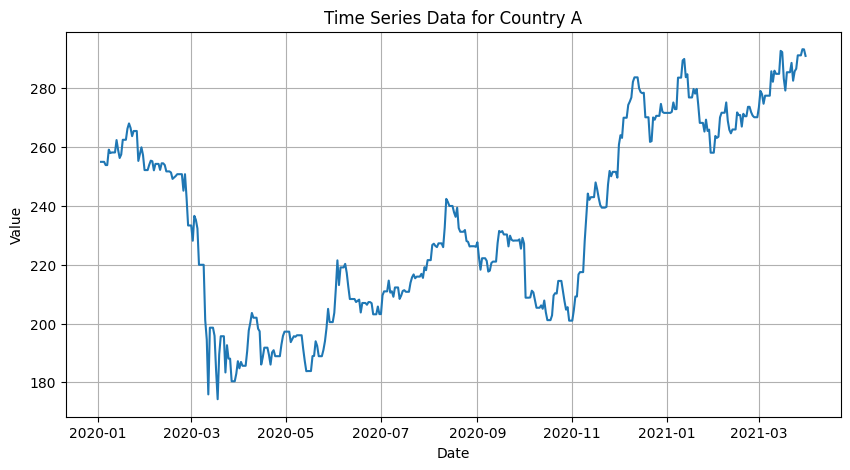

In [13]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Price'])
plt.title('Time Series Data for Country A')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### 1. Moving Average Method

In [12]:
def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

# Parameters
window = 7  # Choose the window size
forecast_horizon = 90  # Number of days to predict

# Split the dataframe into training and test sets
train_series = data['Price'][:-forecast_horizon]
test_series = data['Price'][-forecast_horizon:]

# Extend the training series for predictions
extended_series = train_series.copy()
moving_average_predictions = []

# Generate predictions for the forecast horizon
for _ in range(forecast_horizon):
    forecast_value = moving_average_forecast(extended_series, window)
    moving_average_predictions.append(forecast_value)
    # Append the forecast value to the series
    extended_series = pd.concat([extended_series, pd.Series([forecast_value])], ignore_index=True)

# Convert predictions to a series for comparison
moving_average_predictions_series = pd.Series(moving_average_predictions, index=test_series.index)

predictions_df = pd.DataFrame({
    'Actual': test_series,
    'Predicted': moving_average_predictions_series
})

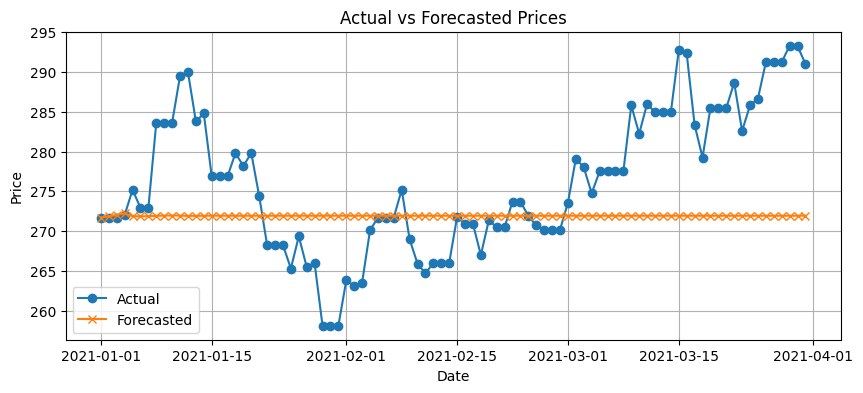

In [13]:
import matplotlib.pyplot as plt

# Plotting actual vs forecasted values
plt.figure(figsize=(10, 4))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual', marker='o')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Forecasted', marker='x')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def calculate_mape(actual, forecast):
    return (abs((actual - forecast) / actual) * 100).mean()

# Calculate MAPE for the actual and forecasted values
mape = calculate_mape(test_series, moving_average_predictions)

print(f"MAPE: {mape:.2f}%")

MAPE: 2.75%


### 2. Exponential Smoothing

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(data['Price'].iloc[:-90], trend='add', seasonal=None, seasonal_periods=None)
model_fit = model.fit()
forecast = model_fit.forecast(90)

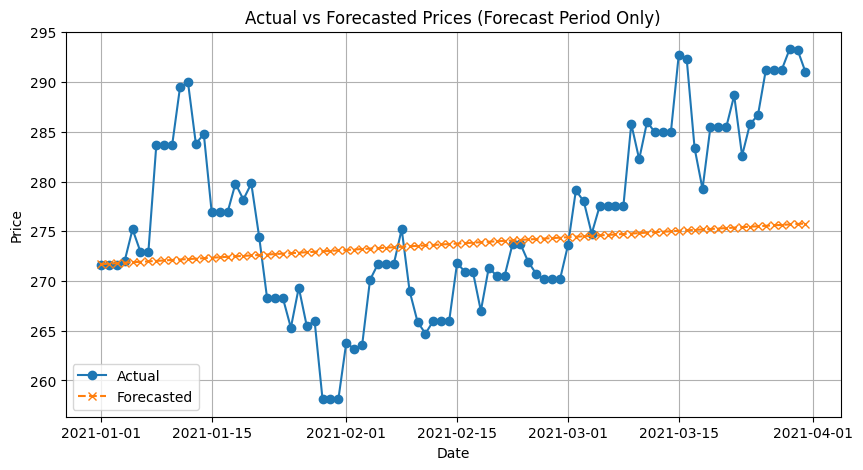

In [18]:
# Extract the actual data for the forecast period
actual_data = data['Price'].iloc[-90:]

# Create a DataFrame to combine actual and forecasted data
forecast_index = actual_data.index

plot_df = pd.DataFrame({
    'Actual': actual_data,
    'Forecasted': forecast
}, index=forecast_index)

# Step 5: Plot the actual vs forecasted values for the forecast period only
plt.figure(figsize=(10, 5))

# Plot actual data
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o')

# Plot forecasted data
plt.plot(plot_df.index, plot_df['Forecasted'], label='Forecasted', linestyle='--', marker='x')

plt.title('Actual vs Forecasted Prices (Forecast Period Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
mape_es = calculate_mape(actual=actual_data, forecast=forecast)
print(f"MAPE: {mape:.2f}%")

MAPE: 2.75%


### 3. ARIMA

In [7]:
# Split the data into training and test sets (optional)
test_days = 90
train_data = data[:-test_days]
test_data = data[-test_days:]

In [11]:
# Fit auto_arima model
model = auto_arima(train_data,
                   seasonal=False,          # Enable seasonal ARIMA
                   m=1,                    # Weekly seasonality for daily data
                   trace=True,             # Print the process
                   error_action='ignore',  # Ignore certain errors
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)          # Perform stepwise search

# Summary of the model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2048.203, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2047.577, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2049.520, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2049.520, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2045.623, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2050.877, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.332 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1021.812
Date:                Thu, 06 Jun 2024   AIC                           2045.623
Time:                        10:56:57   BIC                           2049.518
Sample:                    01-03-2020   HQIC                          2047.171
          

In [19]:
# Forecast the future values
n_periods = 90
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

In [20]:
# Create a DataFrame for the forecast
forecast_index = pd.date_range(start=test_data.index[0], periods=n_periods, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

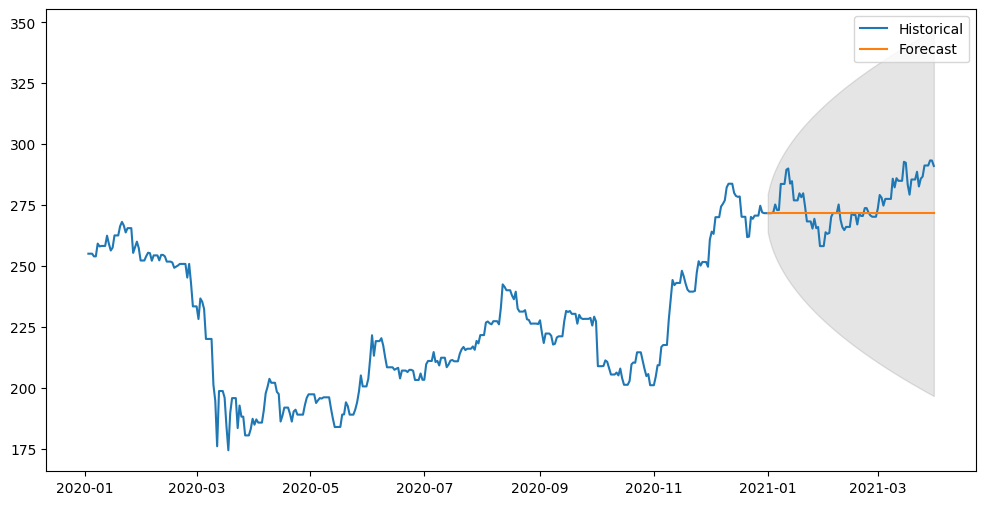

In [22]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical')
plt.plot(forecast_df, label='Forecast')
plt.fill_between(forecast_df.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.show()


In [25]:
# Calculate MAPE for the test data
test_forecast, test_conf_int = model.predict(n_periods=test_days, return_conf_int=True)
test_forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=test_days, freq='D')
test_forecast_df = pd.DataFrame({'Forecast': test_forecast}, index=test_forecast_index)

mape = calculate_mape(test_data, test_forecast_df['Forecast'])
print(f"MAPE: {mape:.2f}%")

MAPE: 2.77%


### 4. Prophet Model

In [39]:
data = load_data()

In [40]:
# Prepare data for Prophet model
df_prophet = data.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})

In [41]:
train_data = df_prophet[:-90]
test_data = df_prophet[-90:]

In [42]:
from prophet import Prophet

# Initialize and fit the model
model = Prophet()
model.fit(train_data)


12:10:05 - cmdstanpy - INFO - Chain [1] start processing
12:10:05 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Create a dataframe with future dates for prediction
future_dates = model.make_future_dataframe(periods=90)

# Make predictions
forecast = model.predict(future_dates)


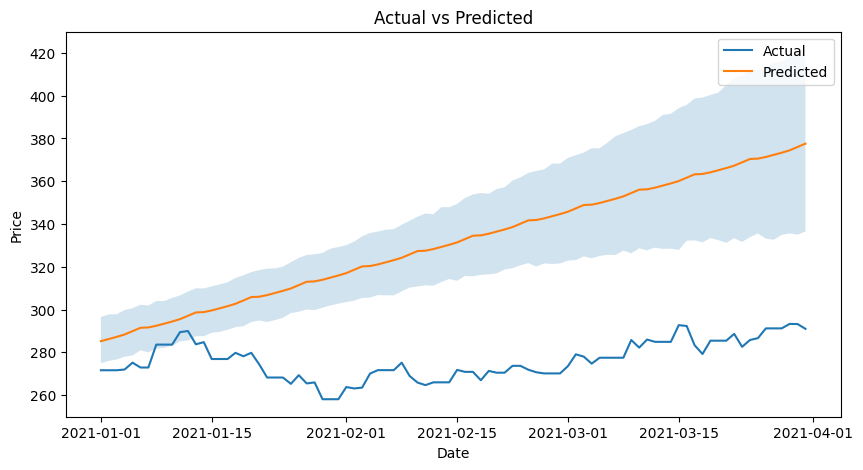

In [44]:
import matplotlib.pyplot as plt

# Compare the predicted and actual values
forecast_test = forecast.set_index('ds').loc[test_data['ds']]

plt.figure(figsize=(10, 5))
plt.plot(test_data['ds'], test_data['y'], label='Actual')
plt.plot(test_data['ds'], forecast_test['yhat'], label='Predicted')
plt.fill_between(test_data['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.2)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [45]:
# Extract the forecast for the test period
forecast_test = forecast.set_index('ds').loc[test_data['ds']]['yhat']

# Ensure indices align
test_data.set_index('ds', inplace=True)

mape = calculate_mape(test_data['y'], forecast_test)
print(f"MAPE: {mape:.2f}%")


MAPE: 19.85%


### 5. LSTM 

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

data = load_data()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [5]:
# Define sequence length
seq_length = 10

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], data.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], data.shape[1]))

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
12/12 [==============================] - 8s 18ms/step - loss: 0.0935
Epoch 2/20
12/12 [==============================] - 0s 28ms/step - loss: 0.0163
Epoch 3/20
12/12 [==============================] - 0s 15ms/step - loss: 0.0123
Epoch 4/20
12/12 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 5/20
12/12 [==============================] - 0s 22ms/step - loss: 0.0060
Epoch 6/20
12/12 [==============================] - 0s 17ms/step - loss: 0.0053
Epoch 7/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0051
Epoch 8/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0052
Epoch 9/20
12/12 [==============================] - 0s 16ms/step - loss: 0.0051
Epoch 10/20
12/12 [==============================] - 0s 17ms/step - loss: 0.0051
Epoch 11/20
12/12 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 12/20
12/12 [==============================] - 0s 17ms/step - loss: 0.0049
Epoch 13/20
12/12 [==================

In [7]:
# Make predictions
predictions = model.predict(X_test)
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
# Inverse transform the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 2s 7ms/step


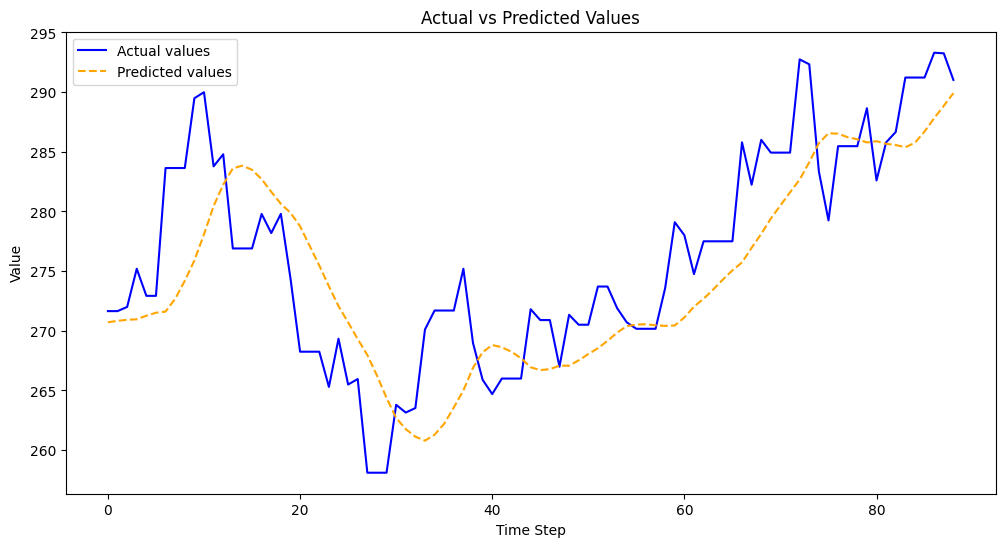

In [29]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual values')

# Plot the predicted values
plt.plot(predictions, color='orange', linestyle='--', label='Predicted values')

# Add labels and legend
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()

In [32]:
mape = calculate_mape(y_test, predictions)
print(f'MAPE: {mape}%')

MAPE: 1.6961774622190249%


Among the time series forecasting techniques, LSTM gives the best results. Bollinger bands can be used to test its effectiveness.

### Bollinger Bands

In [8]:
data = load_data()

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:].copy()

In [9]:
# Align the predictions with the test data
test_data['Predictions'] = np.nan
test_data['Predictions'][-len(predictions):] = predictions.flatten()

# Calculate the moving average and standard deviation using the predicted prices for the test period
window = 20  # Window size for moving average and standard deviation
test_data['SMA'] = test_data['Predictions'].rolling(window).mean()
test_data['SD'] = test_data['Predictions'].rolling(window).std()

# Calculate the Bollinger Bands using the predicted prices for the test period
test_data['Upper Band'] = test_data['SMA'] + (test_data['SD'] * 2)
test_data['Lower Band'] = test_data['SMA'] - (test_data['SD'] * 2)

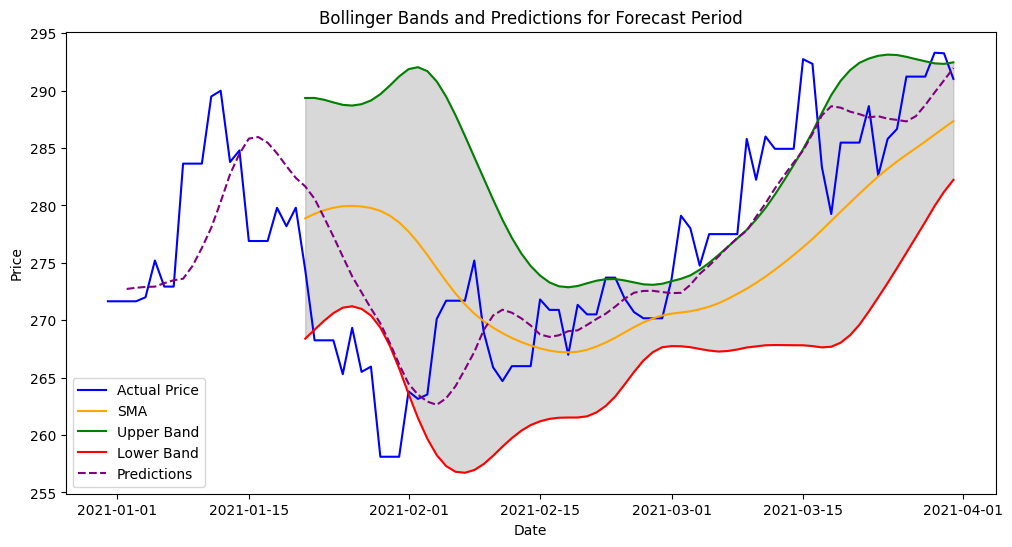

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Price'], label='Actual Price', color='blue')
plt.plot(test_data.index, test_data['SMA'], label='SMA', color='orange')
plt.plot(test_data.index, test_data['Upper Band'], label='Upper Band', color='green')
plt.plot(test_data.index, test_data['Lower Band'], label='Lower Band', color='red')
plt.plot(test_data.index, test_data['Predictions'], label='Predictions', color='purple', linestyle='--')

plt.fill_between(test_data.index, test_data['Upper Band'], test_data['Lower Band'], color='gray', alpha=0.3)
plt.title('Bollinger Bands and Predictions for Forecast Period')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


While most of the actual price falls between the bollinger bands, there are few days where it falls outside the bands, using which we can determine the buy/ sell/ hold strategy

#### Buy/ Sell/ Hold Strategy

In [11]:
# Determine buy/sell/hold strategy
test_data['Signal'] = np.where(test_data['Price'] > test_data['Upper Band'], 'Sell',
                              np.where(test_data['Price'] < test_data['Lower Band'], 'Buy', 'Hold'))

In [13]:
test_data['Signal']

Date
2020-12-31    Hold
2021-01-01    Hold
2021-01-02    Hold
2021-01-03    Hold
2021-01-04    Hold
              ... 
2021-03-27    Hold
2021-03-28    Hold
2021-03-29    Sell
2021-03-30    Sell
2021-03-31    Hold
Freq: D, Name: Signal, Length: 91, dtype: object

### Weekly and Monthly Predictions

Now using the daily predictions, weekly and monthly forecast can be derived by aggregating the daily Predictions to Weekly and Monthly

In [36]:
# Ensure the 'Predictions' column in test_data is not NaN for aggregation
test_data.dropna(subset=['Predictions'], inplace=True)

# Aggregate to weekly predictions using the last prediction of each week (Friday)
weekly_predictions = test_data['Predictions'].resample('W-FRI').last()

# Aggregate to monthly predictions using the last prediction of each month
monthly_predictions = test_data['Predictions'].resample('M').last()


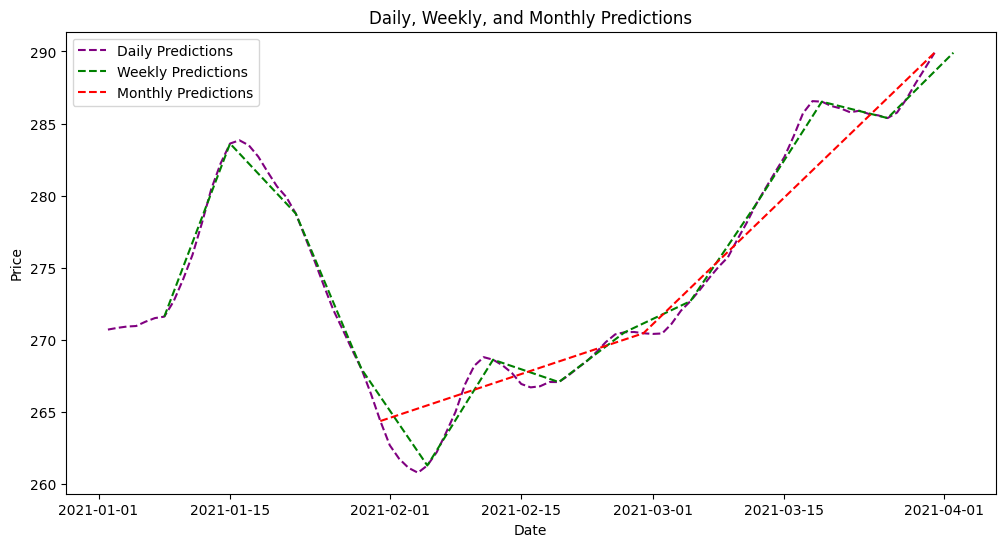

In [37]:
import matplotlib.pyplot as plt

# Plot daily predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Predictions'], label='Daily Predictions', color='purple', linestyle='--')

# Plot weekly predictions
plt.plot(weekly_predictions.index, weekly_predictions, label='Weekly Predictions', color='green', linestyle='--')

# Plot monthly predictions
plt.plot(monthly_predictions.index, monthly_predictions, label='Monthly Predictions', color='red', linestyle='--')

plt.title('Daily, Weekly, and Monthly Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
